**DenseNet121 --- CBIS-DDSM Binary Classifier**\
Goal: replicate the MobileNetV2 pipeline with **DenseNet121** so comparison is fair.\
We'll keep the same preprocessing, splits, and metrics. Today we'll:

1.  set up imports + seeds + paths,

2.  load/merge CSVs → a single dataframe with `image_path` + `label`,

3.  build TF datasets,

4.  train DenseNet121,

5.  evaluate + save plots,

6.  add Grad-CAM.

In [1]:
# --- Core ---
import os, glob, random, json
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- ML / DL ---
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# --- Keras (we’ll import DenseNet later) ---
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- Project paths ---

ROOT = Path(r"d:\Computer Science\UoL\Final Project\breast-cancer-detection")
DATA_DIR = ROOT / "data"
DATA_CSV_DIR = DATA_DIR / "csv"
DATA_JPEG_DIR = DATA_DIR / "kaggle/jpeg"

# Checks
print("CSV dir exists:", DATA_CSV_DIR.exists())
print("JPEG dir exists:", DATA_JPEG_DIR.exists())


CSV dir exists: True
JPEG dir exists: True


In [2]:
# 1) Load the four description CSVs and tag them with lesion type + split
def _read_cbis_csv(path, lesion_type, split):
    df = pd.read_csv(path)
    df["lesion_type"] = lesion_type   # 'calc' or 'mass'
    df["split"] = split               # 'train' or 'test'
    return df

In [3]:
calc_train = _read_cbis_csv(DATA_CSV_DIR / "calc_case_description_train_set.csv", "calc", "train")
calc_test  = _read_cbis_csv(DATA_CSV_DIR / "calc_case_description_test_set.csv",  "calc", "test")
mass_train = _read_cbis_csv(DATA_CSV_DIR / "mass_case_description_train_set.csv", "mass", "train")
mass_test  = _read_cbis_csv(DATA_CSV_DIR / "mass_case_description_test_set.csv",  "mass", "test")

In [4]:
# Concatenate all dataframes into one
raw_df = pd.concat([calc_train, calc_test, mass_train, mass_test], ignore_index=True)

In [5]:
# 2) Find the actual column names for image path + pathology (they vary across releases)
def _get_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found. Columns present:\n{df.columns.tolist()}")

col_imgpath   = _get_col(raw_df, ["image file path", "Image File Path", "image_path", "file_path"])
col_pathology = _get_col(raw_df, ["pathology", "Pathology"])

In [6]:
# 3) Create a clean working frame with consistent column names
df = raw_df.rename(columns={col_imgpath: "source_path", col_pathology: "pathology"}).copy()

In [7]:
# 4) Map pathology -> binary label (benign=0, malignant=1)
def _to_label(v: str):
    v = str(v).strip().lower()
    if "malig" in v:
        return 1
    if "benig" in v or "normal" in v:
        return 0
    return np.nan  # anything unexpected becomes NaN so we can catch it

df["label"] = df["pathology"].map(_to_label).astype("float")

In [8]:
# 5) Extract the DICOM-like case UID from the path
uid_pat = re.compile(r"(\d+(?:\.\d+){6,})")  # “numbers.numbers....” at least 7 segments
df["case_uid"] = df["source_path"].apply(lambda p: uid_pat.search(str(p)).group(1) if uid_pat.search(str(p)) else np.nan)

In [9]:
# 6) Basic sanity checks
print("Rows:", len(df))
print("Null labels:", int(df['label'].isna().sum()))
print("Null UIDs:", int(df['case_uid'].isna().sum()))
print("\nPreview:")
display(df[["lesion_type","split","pathology","label","case_uid"]].head(10))

print("\nLabel distribution:")
print(df["label"].value_counts(dropna=False))
print("\nSplit x Label:")
print(pd.crosstab(df["split"], df["label"]))

Rows: 3568
Null labels: 0
Null UIDs: 0

Preview:


,lesion_type,split,pathology,label,case_uid
0,calc,train,MALIGNANT,1.0,1.3.6.1.4.1.9590.100.1.2.408909860712120272633...
1,calc,train,MALIGNANT,1.0,1.3.6.1.4.1.9590.100.1.2.427517897311902339923...
2,calc,train,BENIGN,0.0,1.3.6.1.4.1.9590.100.1.2.201322325113694962619...
3,calc,train,BENIGN,0.0,1.3.6.1.4.1.9590.100.1.2.370479499712916693322...
4,calc,train,BENIGN_WITHOUT_CALLBACK,0.0,1.3.6.1.4.1.9590.100.1.2.162256682111885666305...
5,calc,train,BENIGN_WITHOUT_CALLBACK,0.0,1.3.6.1.4.1.9590.100.1.2.162256682111885666305...
6,calc,train,BENIGN_WITHOUT_CALLBACK,0.0,1.3.6.1.4.1.9590.100.1.2.162256682111885666305...
7,calc,train,BENIGN_WITHOUT_CALLBACK,0.0,1.3.6.1.4.1.9590.100.1.2.841558427127656604294...
8,calc,train,BENIGN_WITHOUT_CALLBACK,0.0,1.3.6.1.4.1.9590.100.1.2.841558427127656604294...
9,calc,train,BENIGN_WITHOUT_CALLBACK,0.0,1.3.6.1.4.1.9590.100.1.2.841558427127656604294...



Label distribution:
label
0.0    2111
1.0    1457
Name: count, dtype: int64

Split x Label:
label   0.0   1.0
split            
test    428   276
train  1683  1181


Cases indexed: 6774
File type counts: {'full': 6774, 'mask': 3463, 'unknown': 0}
Cases with >=2 jpgs: 3463


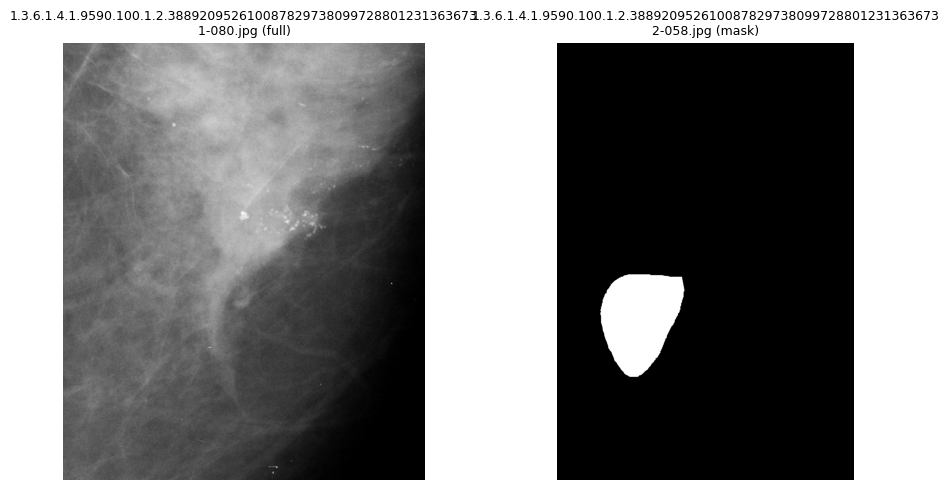

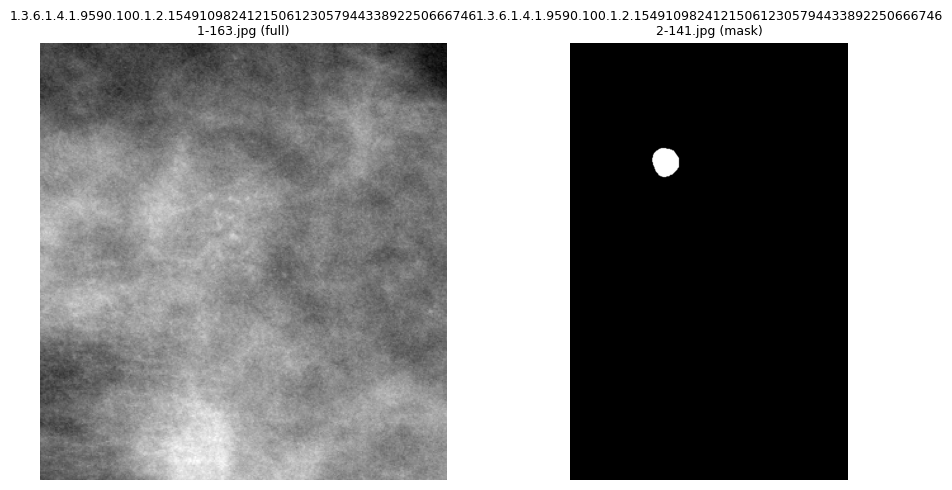

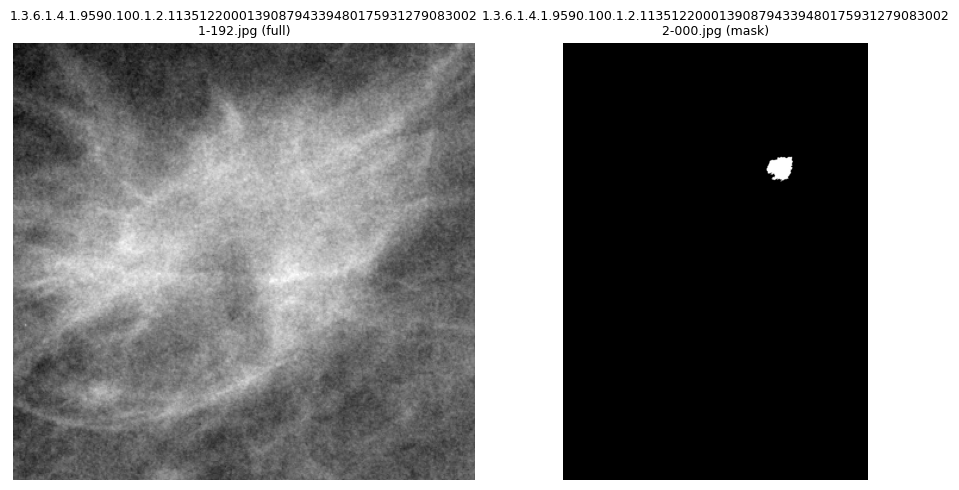

In [10]:
import random

def scan_jpeg_tree(jpeg_root: Path):
    """Return a dict case_uid -> list[{'path': Path, 'image_type': 'full'|'mask'|'unknown'}]."""
    idx = {}
    for case_dir in jpeg_root.iterdir():
        if not case_dir.is_dir():
            continue
        entries = []
        for p in sorted(case_dir.glob("*.jpg")):
            name = p.name.lower()
            if name.startswith("1-"):
                itype = "full"
            elif name.startswith("2-"):
                itype = "mask"
            else:
                itype = "unknown"
            entries.append({"path": p, "image_type": itype})
        if entries:
            idx[case_dir.name] = entries
    return idx

jpeg_index_tagged = scan_jpeg_tree(DATA_JPEG_DIR)
print("Cases indexed:", len(jpeg_index_tagged))

# Quick stats
counts = {"full": 0, "mask": 0, "unknown": 0}
for entries in jpeg_index_tagged.values():
    for e in entries:
        counts[e["image_type"]] += 1
print("File type counts:", counts)

# --- Visual audit: sample a few cases that have >=2 files
def show_case(case_uid, entries):
    images = entries[:2] if len(entries) >= 2 else entries
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    if n == 1: axes = [axes]
    for ax, e in zip(axes, images):
        img = plt.imread(e["path"])
        ax.imshow(img, cmap="gray")
        ax.set_title(f"{case_uid}\n{e['path'].name} ({e['image_type']})", fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

multi_file_cases = [ (uid, entries) for uid, entries in jpeg_index_tagged.items() if len(entries) >= 2 ]
print("Cases with >=2 jpgs:", len(multi_file_cases))

# Show a few random ones to confirm '1-' is full & '2-' is mask/annot
for uid, entries in random.sample(multi_file_cases, k=min(3, len(multi_file_cases))):
    show_case(uid, entries)


In [11]:
# Load the mapping tables you uploaded
meta_path = ROOT / "data" / "csv" / "meta.csv"
dicom_info_path = ROOT / "data" / "csv" / "dicom_info.csv"

meta_df = pd.read_csv(meta_path)
dicom_df = pd.read_csv(dicom_info_path)

# Helper: extract the JPEG folder UID from dicom_info.image_path
# e.g., "CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308.../1-001.jpg" -> that long UID
uid_pat = re.compile(r"CBIS-DDSM/jpeg/(\d+(?:\.\d+){6,})/")

def extract_jpeg_uid(p):
    m = uid_pat.search(str(p))
    return m.group(1) if m else None

dicom_df["jpeg_uid"] = dicom_df["image_path"].apply(extract_jpeg_uid)

# Keep only rows where we successfully extracted a jpeg_uid
dicom_df = dicom_df[~dicom_df["jpeg_uid"].isna()].copy()

# Columns that can contain useful UIDs to map from CSV
uid_cols = [c for c in ["SeriesInstanceUID", "StudyInstanceUID"] if c in dicom_df.columns]

# Build a mapping table: each of these UID columns -> jpeg_uid
mappings = []
for c in uid_cols:
    sub = dicom_df[[c, "jpeg_uid"]].dropna().drop_duplicates()
    sub = sub.rename(columns={c: "source_uid"})
    sub["source_uid"] = sub["source_uid"].astype(str)
    mappings.append(sub)

uid_map_df = pd.concat(mappings, ignore_index=True).drop_duplicates()

print("UID map rows:", len(uid_map_df))
print(uid_map_df.head())


UID map rows: 13548
                                          source_uid  \
0  1.3.6.1.4.1.9590.100.1.2.129308726812851964007...   
1  1.3.6.1.4.1.9590.100.1.2.248386742010678582309...   
2  1.3.6.1.4.1.9590.100.1.2.267213171011171858918...   
3  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...   
4  1.3.6.1.4.1.9590.100.1.2.153339052913121382622...   

                                            jpeg_uid  
0  1.3.6.1.4.1.9590.100.1.2.129308726812851964007...  
1  1.3.6.1.4.1.9590.100.1.2.248386742010678582309...  
2  1.3.6.1.4.1.9590.100.1.2.267213171011171858918...  
3  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...  
4  1.3.6.1.4.1.9590.100.1.2.153339052913121382622...  


In [12]:
df["case_uid"] = df["case_uid"].astype(str)
uid_map_df["source_uid"] = uid_map_df["source_uid"].astype(str)

tmp = df.merge(uid_map_df, left_on="case_uid", right_on="source_uid", how="left")
print("Exact matches:", tmp["jpeg_uid"].notna().sum(), "of", len(tmp))


Exact matches: 3568 of 3568


In [13]:
# Ensure types are strings
df["case_uid"] = df["case_uid"].astype(str)
uid_map_df["source_uid"] = uid_map_df["source_uid"].astype(str)
uid_map_df["jpeg_uid"] = uid_map_df["jpeg_uid"].astype(str)

# Exact merge
df1 = df.merge(uid_map_df, left_on="case_uid", right_on="source_uid", how="left")

exact_matches = df1["jpeg_uid"].notna().sum()
print("Exact jpeg_uid matches:", exact_matches, "of", len(df1))

# If some are still missing, try substring matching fallback
if exact_matches < len(df1):
    # Build fast lookup: any UID we know -> jpeg_uid
    uid_lookup = dict(zip(uid_map_df["source_uid"], uid_map_df["jpeg_uid"]))
    keys = list(uid_lookup.keys())

    def fuzzy_map(u):
        if pd.isna(u):
            return None
        s = str(u)
        if s in uid_lookup:
            return uid_lookup[s]
        # fallback: substring either way
        for k in keys:
            if s in k or k in s:
                return uid_lookup[k]
        return None

    df1.loc[df1["jpeg_uid"].isna(), "jpeg_uid"] = df1.loc[df1["jpeg_uid"].isna(), "case_uid"].apply(fuzzy_map)

print("Total jpeg_uid after fallback:", df1["jpeg_uid"].notna().sum())

# Keep only rows that resolved to a jpeg_uid
df_uids = df1.dropna(subset=["jpeg_uid"]).copy()
print("Resolved rows:", len(df_uids))
print(df_uids[["case_uid","jpeg_uid","pathology","label","split","lesion_type"]].head())


Exact jpeg_uid matches: 3568 of 3568
Total jpeg_uid after fallback: 3568
Resolved rows: 3568
                                            case_uid  \
0  1.3.6.1.4.1.9590.100.1.2.408909860712120272633...   
1  1.3.6.1.4.1.9590.100.1.2.427517897311902339923...   
2  1.3.6.1.4.1.9590.100.1.2.201322325113694962619...   
3  1.3.6.1.4.1.9590.100.1.2.370479499712916693322...   
4  1.3.6.1.4.1.9590.100.1.2.162256682111885666305...   

                                            jpeg_uid                pathology  \
0  1.3.6.1.4.1.9590.100.1.2.474143160103683865197...                MALIGNANT   
1  1.3.6.1.4.1.9590.100.1.2.250596608311207922527...                MALIGNANT   
2  1.3.6.1.4.1.9590.100.1.2.228699627313487111012...                   BENIGN   
3  1.3.6.1.4.1.9590.100.1.2.104743410411133110629...                   BENIGN   
4  1.3.6.1.4.1.9590.100.1.2.406725628213826290127...  BENIGN_WITHOUT_CALLBACK   

   label  split lesion_type  
0    1.0  train        calc  
1    1.0  train        

In [14]:
# Reuse the tagged index
jpeg_index = jpeg_index_tagged  # dict: jpeg_uid -> list of {'path', 'image_type'}

def attach_paths_using_jpeg_uid(df_uids, jpeg_index):
    records = []
    missing = 0
    for _, row in df_uids.iterrows():
        uid = row["jpeg_uid"]
        entries = jpeg_index.get(uid, None)
        if not entries:
            missing += 1
            continue
        fulls = [e["path"] for e in entries if e["image_type"] == "full"]
        masks = [e["path"] for e in entries if e["image_type"] == "mask"]
        mask_path = masks[0] if masks else None
        for full in fulls:
            rec = row.to_dict()
            rec["image_path"] = full
            rec["mask_path"] = mask_path
            records.append(rec)
    out = pd.DataFrame(records)
    print(f"Attached rows: {len(out)} | Missing jpeg_uid folders: {missing}")
    return out

df_imgs = attach_paths_using_jpeg_uid(df_uids, jpeg_index)

print(df_imgs.columns.tolist()[:15])
print(df_imgs[["split","label","jpeg_uid","image_path","mask_path"]].head())
print("\nLabel counts:\n", df_imgs["label"].value_counts())
print("\nSplit x Label:\n", pd.crosstab(df_imgs["split"], df_imgs["label"]))


Attached rows: 3568 | Missing jpeg_uid folders: 0
['patient_id', 'breast density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'calc type', 'calc distribution', 'assessment', 'pathology', 'subtlety', 'source_path', 'cropped image file path', 'ROI mask file path', 'lesion_type']
   split  label                                           jpeg_uid  \
0  train    1.0  1.3.6.1.4.1.9590.100.1.2.474143160103683865197...   
1  train    1.0  1.3.6.1.4.1.9590.100.1.2.250596608311207922527...   
2  train    0.0  1.3.6.1.4.1.9590.100.1.2.228699627313487111012...   
3  train    0.0  1.3.6.1.4.1.9590.100.1.2.104743410411133110629...   
4  train    0.0  1.3.6.1.4.1.9590.100.1.2.406725628213826290127...   

                                          image_path mask_path  
0  d:\Computer Science\UoL\Final Project\breast-c...      None  
1  d:\Computer Science\UoL\Final Project\breast-c...      None  
2  d:\Computer Science\UoL\Final Project\breast-c...      None  
3  d:\Co

***Training begins with Tensor Flow***

**Lock the data + save a snapshot**

In [17]:
df_imgs["image_path"] = df_imgs["image_path"].astype(str)
df_imgs["mask_path"]  = df_imgs["mask_path"].astype(str)  # NaNs become "None" as a string
df_imgs.to_csv(ROOT / "data" / "df_imgs_densenet.csv", index=False)

**Split into train / val / test**

In [18]:
train_df = df_imgs[df_imgs["split"] == "train"].copy()
test_df  = df_imgs[df_imgs["split"] == "test"].copy()

train_df, val_df = train_test_split(
    train_df, test_size=0.20, stratify=train_df["label"], random_state=SEED
)

**Build the TensorFlow input pipeline**

In [19]:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

def load_image(path, label):
    path = tf.convert_to_tensor(path)                 # ensure TF string
    img  = tf.io.read_file(path)                      # read bytes from disk
    img  = tf.io.decode_jpeg(img, channels=1)         # mammos are grayscale
    img  = tf.image.grayscale_to_rgb(img)             # DenseNet expects 3 channels
    img  = tf.image.resize(img, IMG_SIZE, antialias=True)
    img  = tf.cast(img, tf.float32)                   # keep raw 0..255 here
    return img, tf.cast(label, tf.float32)


**Dataset builder**

In [20]:
def make_ds(df, shuffle=False):
    paths  = df["image_path"].values.astype(str)
    labels = df["label"].values.astype(np.float32)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(df), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE) # parallel decode/resize
    ds = ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) # speed-ups
    return ds


**Create the three datasets**

In [21]:
train_ds = make_ds(train_df, shuffle=True)
val_ds   = make_ds(val_df,   shuffle=False)
test_ds  = make_ds(test_df,  shuffle=False)

xb, yb = next(iter(train_ds))
print("Batch shapes:", xb.shape, yb.shape)


Batch shapes: (32, 224, 224, 3) (32,)


**Adjust class weights**

Our classes are ~59% benign (0) vs ~41% malignant (1).

In [23]:
# Compute class weights
n0, n1 = int((df_imgs["label"]==0).sum()), int((df_imgs["label"]==1).sum())
tot = n0 + n1
class_weight = {0: tot/(2*n0), 1: tot/(2*n1)}

Training cell
--------------------------------------------------------------

-   uses ImageNet weights

-   DenseNet preprocess is inside the model

-   checkpoints best model, early stops, reduces LR on plateau

In [24]:
# --- DenseNet121 model ---
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

IMG_SIZE = (224, 224)

base = DenseNet121(include_top=False, weights="imagenet",
                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze backbone for warm-up
for layer in base.layers:
    layer.trainable = False

inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = Lambda(densenet_preprocess, name="preprocess")(inputs)
x = base(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs, name="DenseNet121_breast_cancer")

model.compile(optimizer=Adam(1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy", Precision(name="precision"), Recall(name="recall")])

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step



Model: "DenseNet121_breast_cancer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Lambda)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [25]:
# --- Callbacks & paths ---
ckpt_path = ROOT / "models" / "densenet121_best.keras"
ckpt_path.parent.mkdir(parents=True, exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(str(ckpt_path), monitor="val_accuracy",
                                       save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5,
                                     restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                         patience=2, verbose=1)
]

In [26]:
# --- Train: warm-up ---
EPOCHS_WARMUP = 4
history_warmup = model.fit(
    train_ds, validation_data=val_ds,
    epochs=EPOCHS_WARMUP, callbacks=callbacks,
    class_weight=class_weight if 'class_weight' in globals() else None,
    verbose=1
)

Epoch 1/4
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5002 - loss: 0.7704 - precision: 0.4231 - recall: 0.6333
Epoch 1: val_accuracy improved from None to 0.54625, saving model to d:\Computer Science\UoL\Final Project\breast-cancer-detection\models\densenet121_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.5146 - loss: 0.7587 - precision: 0.4317 - recall: 0.5587 - val_accuracy: 0.5462 - val_loss: 0.6885 - val_precision: 0.4545 - val_recall: 0.5085 - learning_rate: 1.0000e-04
Epoch 2/4
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5288 - loss: 0.7492 - precision: 0.4378 - recall: 0.5673
Epoch 2: val_accuracy improved from 0.54625 to 0.55672, saving model to d:\Computer Science\UoL\Final Project\breast-cancer-detection\models\densenet121_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.5321 - loss: 0.7426 - precision: 0.4456 - recall: 0.5503 - val_accuracy: 0.5567 - val_loss: 0.6781 - val_precision: 0.4651 - val_recall: 0.5085 - learning_ra

In [27]:
# --- Fine-tune: unfreeze top DenseNet blocks ---
for layer in base.layers[-100:]:
    layer.trainable = True

# Optional: track AUC too (nice for binary tasks)
from tensorflow.keras.metrics import AUC
metrics = ["accuracy", Precision(name="precision"), Recall(name="recall"), AUC(name="auc")]

model.compile(optimizer=Adam(1e-5),
              loss="binary_crossentropy",
              metrics=metrics)

EPOCHS_FT = 12
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT,
    callbacks=callbacks,  # still fine to monitor val_accuracy
    class_weight=class_weight if 'class_weight' in globals() else None,
    verbose=1
)

Epoch 1/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6006 - auc: 0.6006 - loss: 0.7428 - precision: 0.5108 - recall: 0.3320
Epoch 1: val_accuracy improved from 0.59860 to 0.64398, saving model to d:\Computer Science\UoL\Final Project\breast-cancer-detection\models\densenet121_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.6010 - auc: 0.6109 - loss: 0.7327 - precision: 0.5224 - recall: 0.3820 - val_accuracy: 0.6440 - val_auc: 0.6965 - val_loss: 0.6278 - val_precision: 0.5650 - val_recall: 0.5890 - learning_rate: 1.0000e-05
Epoch 2/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6329 - auc: 0.6697 - loss: 0.6610 - precision: 0.5499 - recall: 0.5223
Epoch 2: val_accuracy improved from 0.64398 to 0.68237, saving model to d:\Computer Science\UoL\Final Project\breast-cancer-detection\models\densenet121_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.6478 - auc: 0.6884 - loss: 0.6504 - precision: 0.5760 - recall: 0.5534 - val_accuracy: 0.682

Test Accuracy:  0.6065
Test Precision: 0.4987
Test Recall:    0.6739
Test F1:        0.5732
Test AUC:       0.6973

Classification report:
               precision    recall  f1-score   support

           0     0.7281    0.5631    0.6350       428
           1     0.4987    0.6739    0.5732       276

    accuracy                         0.6065       704
   macro avg     0.6134    0.6185    0.6041       704
weighted avg     0.6381    0.6065    0.6108       704



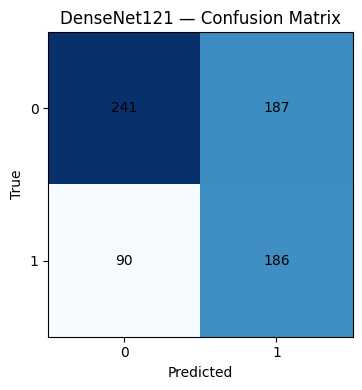

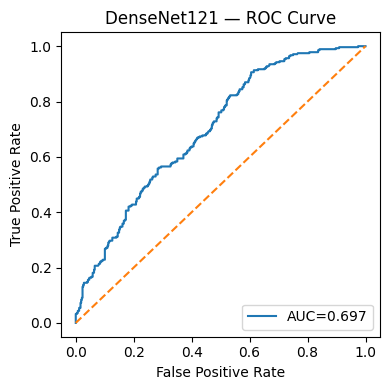

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# --- Predict on test set ---
y_true, y_prob = [], []
for xb, yb in test_ds:
    p = model.predict(xb, verbose=0).ravel()
    y_prob.append(p); y_true.append(yb.numpy())
y_true = np.concatenate(y_true).astype(int)
y_prob = np.concatenate(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

# --- Metrics ---
acc  = (y_pred == y_true).mean()
prec = ((y_pred & (y_true==1)).sum() / max((y_pred==1).sum(), 1))
rec  = ((y_pred & (y_true==1)).sum() / (y_true==1).sum())
f1   = 2*prec*rec / (prec+rec) if (prec+rec)>0 else 0.0
auc  = roc_auc_score(y_true, y_prob)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1:        {f1:.4f}")
print(f"Test AUC:       {auc:.4f}")
print('\nClassification report:\n', classification_report(y_true, y_pred, digits=4))

# --- Save figures ---
figdir = ROOT / "figures"; figdir.mkdir(parents=True, exist_ok=True)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap="Blues"); ax.set_title("DenseNet121 — Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
for (i,j), v in np.ndenumerate(cm): ax.text(j, i, str(v), ha='center', va='center')
plt.tight_layout(); plt.savefig(figdir/"densenet_confusion_matrix.png", dpi=150); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("DenseNet121 — ROC Curve"); plt.legend(loc="lower right")
plt.tight_layout(); plt.savefig(figdir/"densenet_roc.png", dpi=150); plt.show()


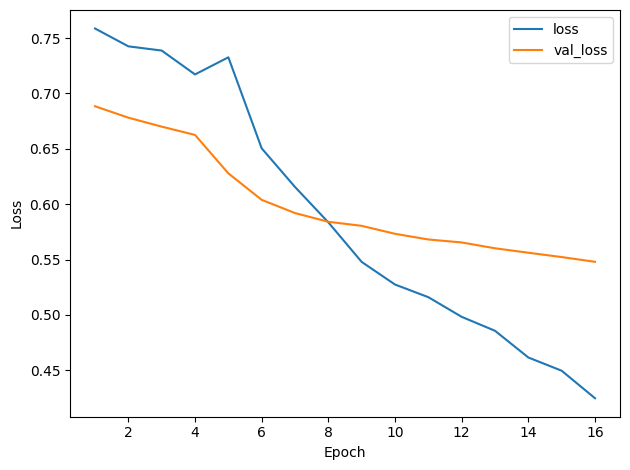

Saved d:\Computer Science\UoL\Final Project\breast-cancer-detection\figures\densenet_loss.png


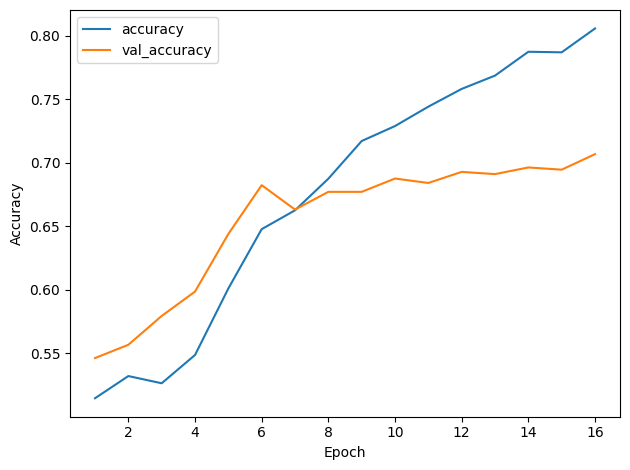

Saved d:\Computer Science\UoL\Final Project\breast-cancer-detection\figures\densenet_accuracy.png


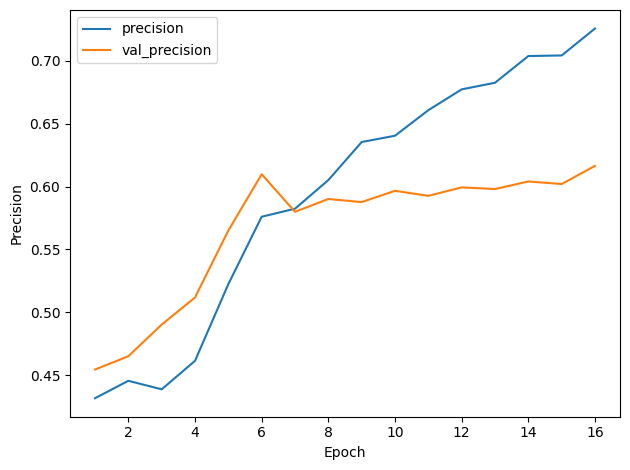

Saved d:\Computer Science\UoL\Final Project\breast-cancer-detection\figures\densenet_precision.png


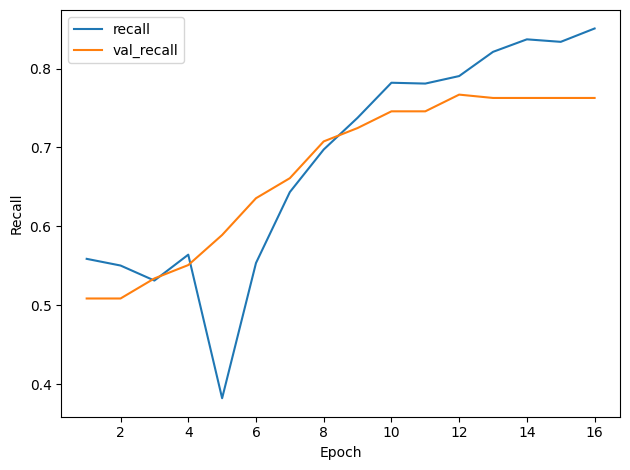

Saved d:\Computer Science\UoL\Final Project\breast-cancer-detection\figures\densenet_recall.png


In [29]:
# --- Plot training curves ---
import matplotlib.pyplot as plt

def plot_history(hists, keys=("loss","accuracy","precision","recall"), outdir=ROOT/"figures"):
    outdir.mkdir(parents=True, exist_ok=True)
    hist = {}
    for h in hists:
        for k, v in h.history.items():
            hist.setdefault(k, []).extend(v)
    epochs = range(1, len(next(iter(hist.values())))+1)
    for k in keys:
        if k in hist and f"val_{k}" in hist:
            plt.figure()
            plt.plot(epochs, hist[k], label=k)
            plt.plot(epochs, hist[f"val_{k}"], label=f"val_{k}")
            plt.xlabel("Epoch"); plt.ylabel(k.title()); plt.legend(); plt.tight_layout()
            fp = outdir / f"densenet_{k}.png"
            plt.savefig(fp, dpi=150)
            plt.show()
            print("Saved", fp)

plot_history([history_warmup, history_ft])

In [31]:
# === DenseNet121 — TEST EVALUATION ===
import numpy as np, json
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_auc_score, roc_curve, confusion_matrix
)
import pandas as pd

figdir = ROOT / "figures"; figdir.mkdir(parents=True, exist_ok=True)
artdir = ROOT / "artifacts"; artdir.mkdir(parents=True, exist_ok=True)

# 1) Collect predictions
y_true, y_prob, img_paths = [], [], []
for xb, yb in test_ds:
    p = model.predict(xb, verbose=0).ravel()
    y_prob.append(p)
    y_true.append(yb.numpy())
# Flatten
y_true = np.concatenate(y_true).astype(int)
y_prob = np.concatenate(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

# Also keep image paths in the same order as test_ds
# Recreate a flat list of test file paths in dataset order
test_paths_flat = []
for p in test_df["image_path"].astype(str).values:
    test_paths_flat.append(p)
# Length check (defensive)
if len(test_paths_flat) != len(y_true):
    print("Warning: path/label length mismatch (will still save metrics).")

In [32]:
# 2) Metrics
metrics = {
    "accuracy": float(accuracy_score(y_true, y_pred)),
    "precision": float(precision_score(y_true, y_pred, zero_division=0)),
    "recall": float(recall_score(y_true, y_pred, zero_division=0)),
    "f1": float(f1_score(y_true, y_pred, zero_division=0)),
    "auc": float(roc_auc_score(y_true, y_prob))
}
print("=== DenseNet121 — Test Metrics ===")
for k,v in metrics.items(): print(f"{k:>9}: {v:.4f}")
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4, zero_division=0))

# Save metrics
with open(artdir / "densenet121_test_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

=== DenseNet121 — Test Metrics ===
 accuracy: 0.6065
precision: 0.4987
   recall: 0.6739
       f1: 0.5732
      auc: 0.6973

Classification report:
               precision    recall  f1-score   support

           0     0.7281    0.5631    0.6350       428
           1     0.4987    0.6739    0.5732       276

    accuracy                         0.6065       704
   macro avg     0.6134    0.6185    0.6041       704
weighted avg     0.6381    0.6065    0.6108       704



In [33]:
# 3) Save per-image predictions for later Grad-CAM picking
pred_df = pd.DataFrame({
    "image_path": test_paths_flat[:len(y_true)],
    "true": y_true,
    "prob_malignant": y_prob,
    "pred": y_pred
})
pred_csv = artdir / "densenet121_test_predictions.csv"
pred_df.to_csv(pred_csv, index=False)
print("Saved predictions to:", pred_csv)

Saved predictions to: d:\Computer Science\UoL\Final Project\breast-cancer-detection\artifacts\densenet121_test_predictions.csv


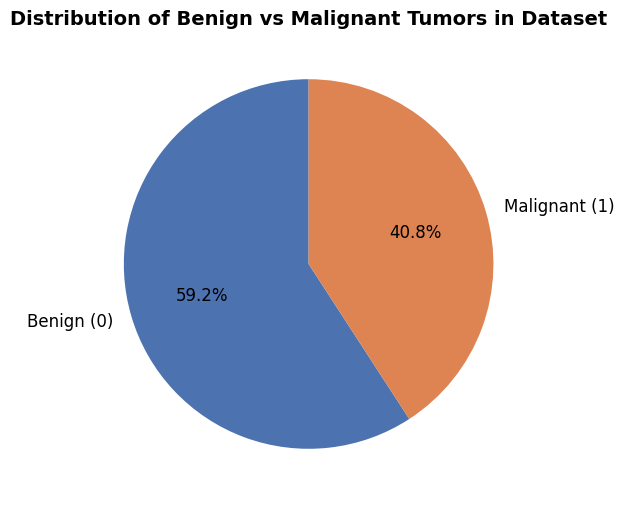

In [35]:
# --- Pie chart of label distribution (professional style) ---
import matplotlib.pyplot as plt

label_counts = df_imgs["label"].value_counts().sort_index()

labels = ["Benign (0)", "Malignant (1)"]
sizes = [label_counts[0.0], label_counts[1.0]]
colors = ["#4c72b0", "#dd8452"]  # muted blue + muted orange/brown

plt.figure(figsize=(6,6))
plt.pie(
    sizes, labels=labels, autopct="%1.1f%%", startangle=90,
    colors=colors, textprops={'fontsize': 12}
)
plt.title("Distribution of Benign vs Malignant Tumors in Dataset", fontsize=14, weight='bold')
plt.show()


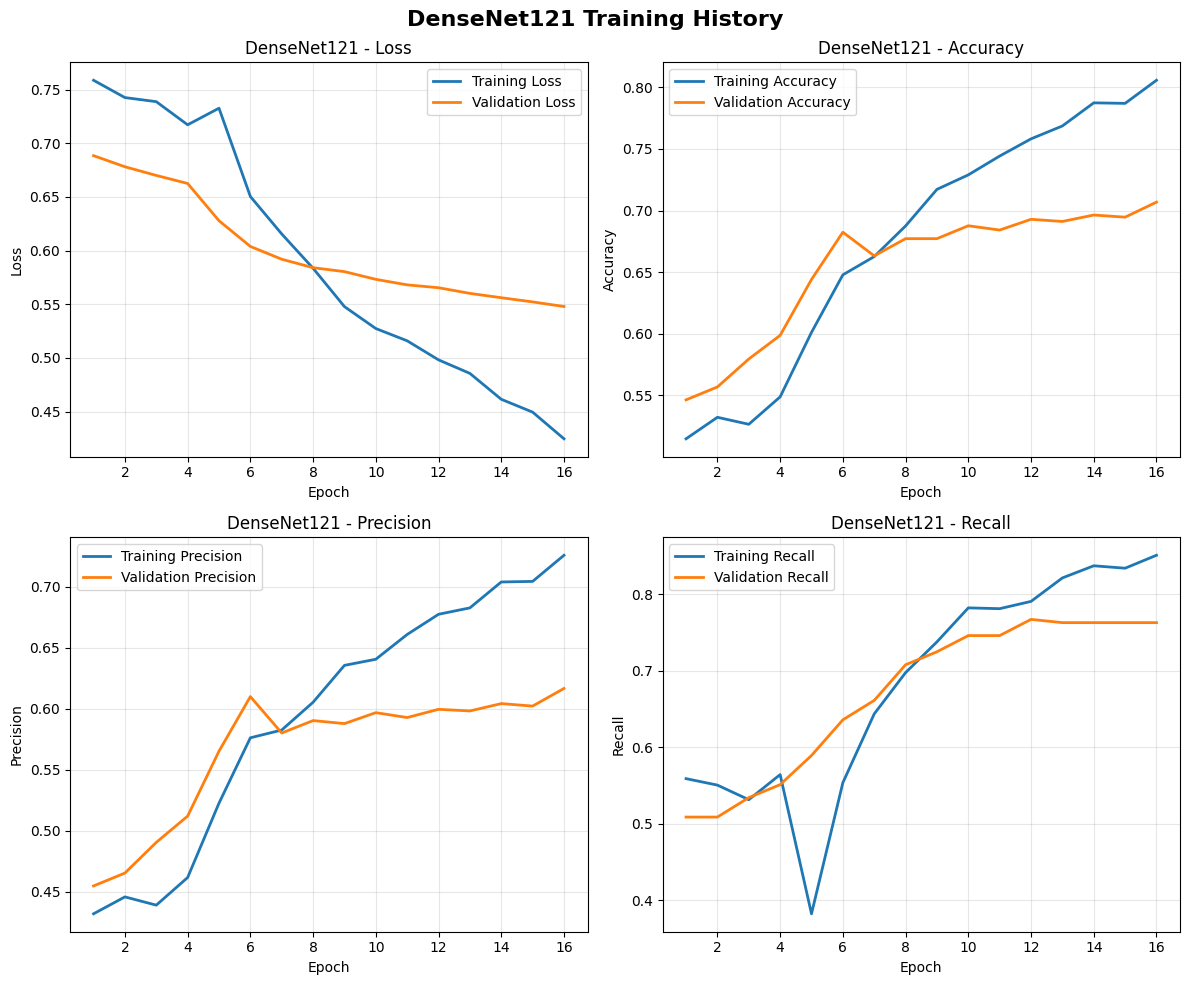

Saved combined training curves to: d:\Computer Science\UoL\Final Project\breast-cancer-detection\figures\densenet121_training_history.png


In [36]:
# --- Plot training curves as subplots ---
import matplotlib.pyplot as plt

def plot_history(hists, keys=("loss","accuracy","precision","recall"), outdir=ROOT/"figures"):
    outdir.mkdir(parents=True, exist_ok=True)
    hist = {}
    for h in hists:
        for k, v in h.history.items():
            hist.setdefault(k, []).extend(v)
    
    epochs = range(1, len(next(iter(hist.values())))+1)
    
    # Filter keys that actually exist in history
    available_keys = [k for k in keys if k in hist and f"val_{k}" in hist]
    n_plots = len(available_keys)
    
    if n_plots == 0:
        print("No valid metrics found in history")
        return
    
    # Create subplots grid (2x2 for 4 metrics, adjust as needed)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # Make it easier to index
    
    for i, k in enumerate(available_keys):
        ax = axes[i]
        ax.plot(epochs, hist[k], label=f"Training {k.title()}", linewidth=2)
        ax.plot(epochs, hist[f"val_{k}"], label=f"Validation {k.title()}", linewidth=2)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(k.title())
        ax.set_title(f"DenseNet121 - {k.title()}")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle("DenseNet121 Training History", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save the combined plot
    fp = outdir / "densenet121_training_history.png"
    plt.savefig(fp, dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved combined training curves to:", fp)

plot_history([history_warmup, history_ft])